In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import auc, roc_curve, plot_roc_curve, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

## Load Data
Data was downloaded from kaggle in June 2020: https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset

In [2]:
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## Data Preprocessing: Get to know and process the data for useful analysis

In [3]:
df.shape

(1470, 35)

In [4]:
df.isnull().sum().any()

False

#### Nominal values
Binary Data: Replace Strings with binaries.

In [5]:
df['Attrition'].replace({'Yes':1, 'No':0}, inplace = True)
df['Gender'].replace({'Female':1, 'Male':0}, inplace = True)
df['OverTime'].replace({'Yes':1, 'No':0}, inplace = True)

One-Hot-Encode and drop the oringinal and one newly created (one-hot-encoded) feature to avoid perfect multicollinearity.

In [6]:
df_D_OHE = pd.get_dummies(df['Department'])
df = pd.concat([df, df_D_OHE], axis=1)
df.rename(columns={'Sales':'Dep_Sales', 
                   'Research & Development':'Dep_Research & Development', 
                   'Human Resources':'Dep_Human Resources'}, inplace=True)

df_EF_OHE = pd.get_dummies(df['EducationField'])
df = pd.concat([df, df_EF_OHE], axis=1)
df.rename(columns={'Life Sciences':'EF_Life Sciences', 
                   'Other':'EF_Other', 
                   'Medical':'EF_Medical',
                   'Marketing':'EF_Marketing',
                   'Technical Degree':'EF_Technical Degree',
                   'Human Resources':'EF_Human Resources'}, inplace=True)

df_JR_OHE = pd.get_dummies(df['JobRole'])
df = pd.concat([df, df_JR_OHE], axis=1)
df.rename(columns={'Sales Executive':'JR_Sales Executive', 
                   'Research Scientist':'JR_Research Scientist', 
                   'Laboratory Technician':'JR_Laboratory Technician',
                   'Manufacturing Director':'JR_Manufacturing Director', 
                   'Healthcare Representative':'JR_Healthcare Representative', 
                   'Manager':'JR_Manager',
                   'Sales Representative':'JR_Sales Representative', 
                   'Research Director':'JR_Research Director', 
                   'Human Resources':'JR_Human Resources'}, inplace=True)   

df_MS_OHE = pd.get_dummies(df['MaritalStatus'])
df = pd.concat([df, df_MS_OHE], axis=1)
df.rename(columns={'Single':'MS_Single', 'Married':'MS_Married', 'Divorced':'MS_Divorced'}, inplace=True)

df = df.drop(['Department', 'Dep_Sales', 'EducationField', 'EF_Life Sciences',
             'JobRole', 'JR_Manager', 'MaritalStatus', 'MS_Single'], axis=1)

#### Ordinal Values
Replace Strings by values

In [7]:
df['BusinessTravel'].replace({'Non-Travel':1, 
                              'Travel_Rarely':2,
                              'Travel_Frequently':3}, inplace = True)

#### Eliminate redundant data
For features *EmployeeCount*, *StandardHours* and *Over18* provide the same values per observation. For *EmployeeNumber* only indexing data is displayed. All these features can be dropped from the DataFrame without any losses.

In [8]:
df=df.drop(['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber'], axis=1)

#### Check for Class Imbalance

In [9]:
print("0: ", df[df['Attrition']==0].count()['Attrition'])
print("1: ", df[df['Attrition']==1].count()['Attrition'])

0:  1233
1:  237


## Save DataFrame
Useful for later use in other approaches, but not necessary.

In [10]:
df.to_csv('df_preprocessed.csv', index=False)

## Upsample Data
Upsample Minority Class

In [11]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df['Attrition']==0]
df_minority = df[df['Attrition']==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, replace=True, n_samples=1233, random_state=8257) 

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

df_upsampled.shape

(2466, 44)

In [12]:
print("0: ", df_upsampled[df_upsampled['Attrition']==0].count()['Attrition'])
print("1: ", df_upsampled[df_upsampled['Attrition']==1].count()['Attrition'])

0:  1233
1:  1233


## Visualize correlations in a heatmap

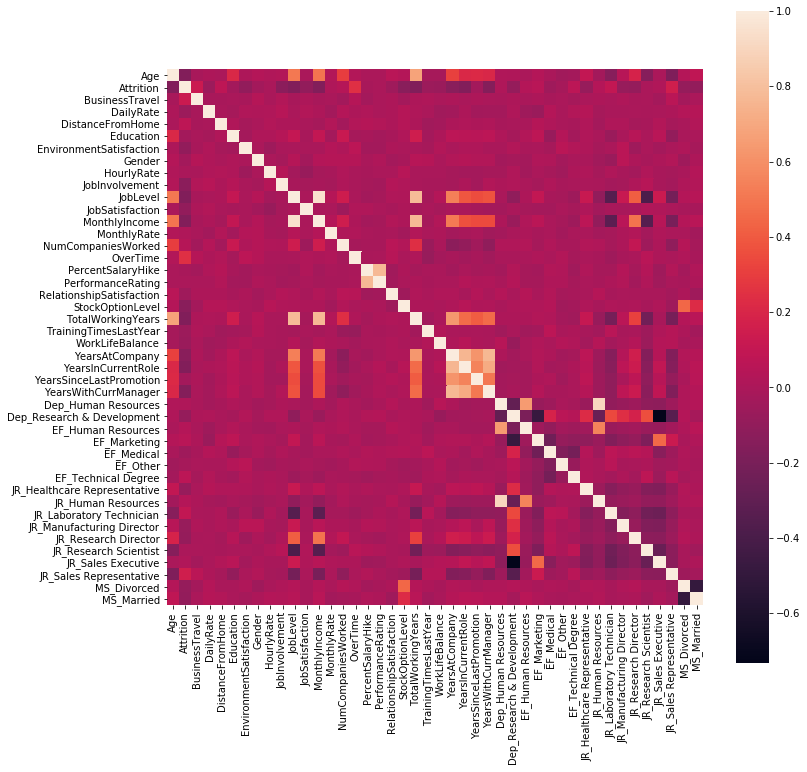

In [13]:
plt.figure(figsize=[12,12])
sns.heatmap(df.corr(), annot=False, fmt='.2f', square=True)

### Distribution plots
Uniform Distributions are found for features *DailyRate*, *HourlyRate* and *MonthlyRate*. These features are not expected to significantly impact *Attrition* analysis.

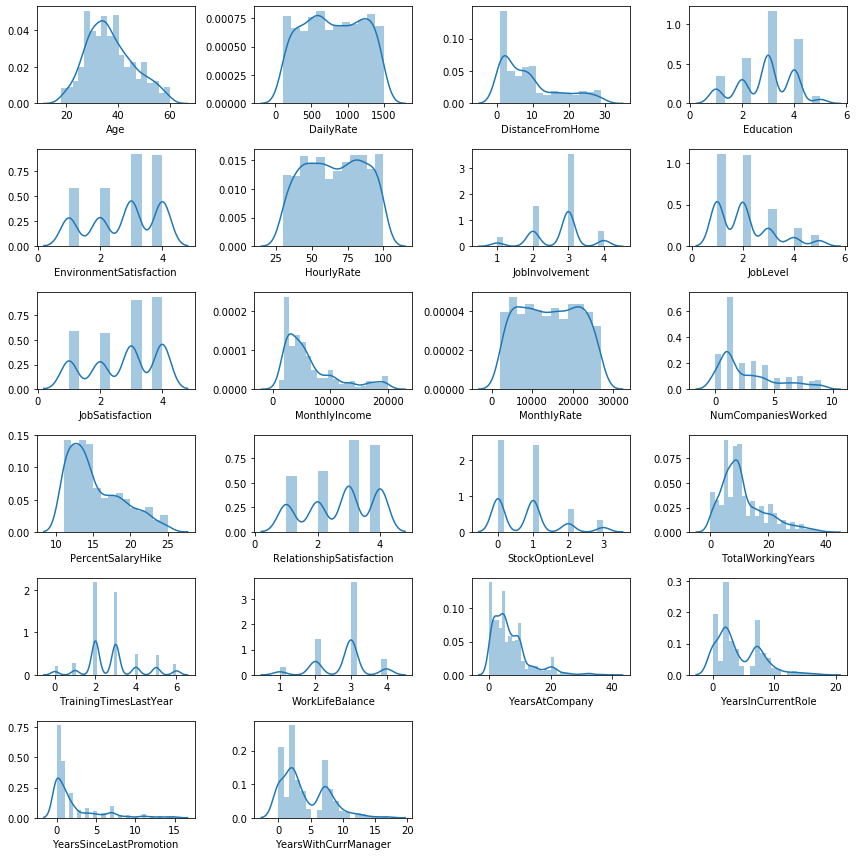

In [14]:
parameter_list = ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 
                  'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 
                  'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 
                  'NumCompaniesWorked', 'PercentSalaryHike', 'RelationshipSatisfaction', 
                  'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 
                  'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 
                  'YearsSinceLastPromotion', 'YearsWithCurrManager']
plt.figure(figsize=(12,12))
for i,elem in enumerate(parameter_list,1):    
    plt.subplot(6,4,i)
    sns.distplot(df[elem])            
    plt.xlabel(elem)
    plt.tight_layout()

### Comparative Plots: Violinplot
All data is available as integers. It is therefore visualized using violin plots.

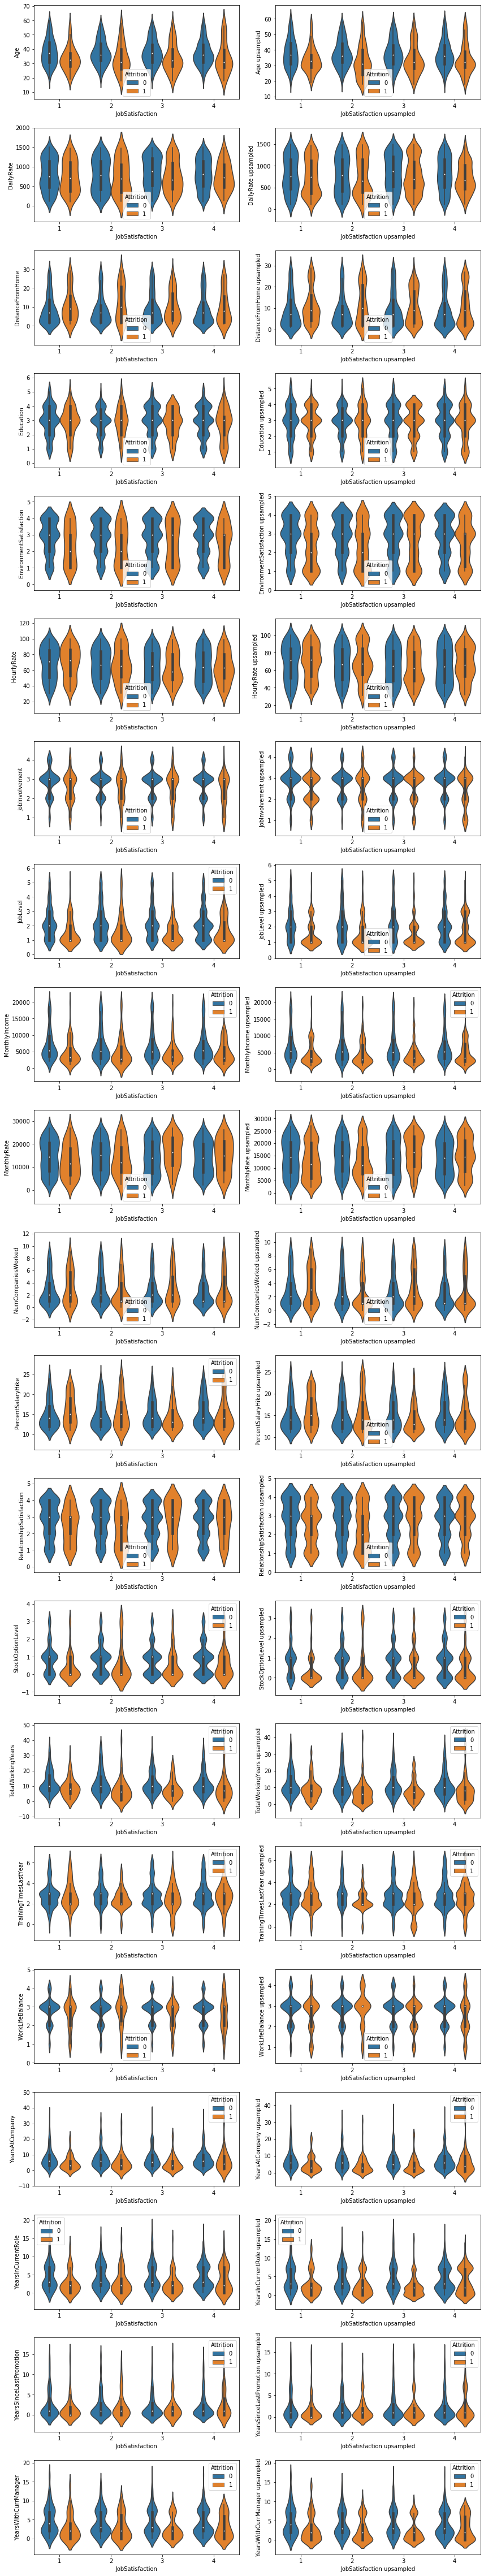

In [15]:
parameter_list_vp = ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 
                  'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 
                  'JobLevel', 'MonthlyIncome', 'MonthlyRate', 
                  'NumCompaniesWorked', 'PercentSalaryHike', 'RelationshipSatisfaction', 
                  'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 
                  'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 
                  'YearsSinceLastPromotion', 'YearsWithCurrManager']
plt.figure(figsize=(12,72))
for i,elem in enumerate(parameter_list_vp,1):
    plt.subplot(24,2,i*2-1) 
    sns.violinplot(x='JobSatisfaction', y=elem, hue='Attrition', data=df)
    plt.xlabel('JobSatisfaction')
    plt.ylabel(elem)    
    plt.subplot(24,2,i*2) 
    sns.violinplot(x='JobSatisfaction', y=elem, hue='Attrition', data=df_upsampled)
    plt.xlabel('JobSatisfaction upsampled')
    plt.ylabel(str(elem)+' upsampled')    
    plt.tight_layout()

#### Descriptive Statistics

In [16]:
df = df_upsampled

In [17]:
df.describe(include='all')

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,...,JR_Healthcare Representative,JR_Human Resources,JR_Laboratory Technician,JR_Manufacturing Director,JR_Research Director,JR_Research Scientist,JR_Sales Executive,JR_Sales Representative,MS_Divorced,MS_Married
count,2466.000000,2466.000000,2466.000000,2466.000000,2466.000000,2466.000000,2466.000000,2466.000000,2466.000000,2466.000000,...,2466.000000,2466.000000,2466.000000,2466.000000,2466.000000,2466.000000,2466.000000,2466.000000,2466.000000,2466.000000
mean,35.617599,0.500000,2.149230,782.187753,9.927818,2.911598,2.644363,0.377940,66.481752,2.651257,...,0.071776,0.042985,0.202352,0.080292,0.034874,0.205596,0.226683,0.089619,0.185726,0.417680
std,9.369546,0.500101,0.538604,402.496497,8.339188,1.013245,1.126683,0.484971,20.160328,0.733460,...,0.258169,0.202864,0.401835,0.271800,0.183499,0.404219,0.418771,0.285693,0.388964,0.493277
min,18.000000,0.000000,1.000000,102.000000,1.000000,1.000000,1.000000,0.000000,30.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,0.000000,2.000000,431.250000,2.000000,2.000000,2.000000,0.000000,50.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,34.000000,0.500000,2.000000,750.000000,8.000000,3.000000,3.000000,0.000000,67.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,41.000000,1.000000,2.000000,1136.000000,16.000000,4.000000,4.000000,1.000000,84.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,60.000000,1.000000,3.000000,1499.000000,29.000000,5.000000,4.000000,1.000000,100.000000,4.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Data Assignment, Scaling and Data Split

In [18]:
Xy = df[['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'DistanceFromHome',
       'Education', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'Dep_Human Resources',
       'Dep_Research & Development', 'EF_Human Resources', 'EF_Marketing',
       'EF_Medical', 'EF_Other', 'EF_Technical Degree',
       'JR_Healthcare Representative', 'JR_Human Resources',
       'JR_Laboratory Technician', 'JR_Manufacturing Director',
       'JR_Research Director', 'JR_Research Scientist', 'JR_Sales Executive',
       'JR_Sales Representative', 'MS_Divorced', 'MS_Married']]
y = Xy['Attrition']
X = Xy.drop(['Attrition'], axis = 1)
X.shape, y.shape

((2466, 43), (2466,))

In [19]:
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=42)

## Machine Learning: Try different classifier models
#### Logistic Regression

In [21]:
lr = LogisticRegression()
param_grid = {'C': [0.01, 0.1, 1, 5],
              'solver': ['sag', 'saga']} 

grid = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5 )
grid_result = grid.fit(X_train, y_train)

print("best score: " +  str(grid.best_score_))
print("best C: " + str(grid.best_estimator_.C))
print("best solver: " + str(grid.best_estimator_.solver))

best score: 0.7674503772064748
best C: 0.1
best solver: sag


#### Random Forest Classifier

In [22]:
rf = RandomForestClassifier()
param_grid_rf = {'n_estimators' : [20,35,50,65,80],
                'max_depth': [5,7,9],
                'bootstrap': [True, False]}
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=6)
grid_result_rf = grid_rf.fit(X_train, y_train)

print("best score: " +  str(grid_rf.best_score_))
print("best n_estimators: " + str(grid_rf.best_estimator_.n_estimators))
print("best max_depth: " + str(grid_rf.best_estimator_.max_depth))
print('Best bootstrap: ', grid_rf.best_estimator_.bootstrap)

best score: 0.9513249695288529
best n_estimators: 65
best max_depth: 9
Best bootstrap:  False


#### SVC

In [23]:
scv = SVC()
param_grid_scv = {'C' : [0.01, 0.1, 1, 2, 5, 10, 25],
                'kernel': ['poly', 'rbf', 'sigmoid'],
                'degree': [3,4,5,6],
                'gamma': ['scale', 'auto']}

grid_scv = GridSearchCV(estimator=scv, param_grid=param_grid_scv, cv=6 )
grid_result_scv = grid_scv.fit(X_train, y_train)

print("best score: " +  str(grid_scv.best_score_))
print("best C: " + str(grid_scv.best_estimator_.C))
print("best kernel: " + str(grid_scv.best_estimator_.kernel))
print("best degree: " + str(grid_scv.best_estimator_.degree))
print('Best gamma: ', grid_scv.best_estimator_.gamma)

best score: 0.9502339623698847
best C: 25
best kernel: poly
best degree: 5
Best gamma:  scale


#### k-nearest Neighbor

In [24]:
kn = KNeighborsClassifier(n_jobs=-1)
param_grid_kn = {'n_neighbors' : [2,3,4,5,7,10,15],
                'weights': ['uniform', 'distance'],
                'algorithm': ['auto','ball_tree','kd_tree','brute']}

grid_kn = GridSearchCV(estimator=kn, param_grid=param_grid_kn, cv=6 )
grid_result_kn = grid_kn.fit(X_train, y_train)

print("best score: " +  str(grid_kn.best_score_))
print("best n_neighbors: " + str(grid_kn.best_estimator_.n_neighbors))
print("best weights: " + str(grid_kn.best_estimator_.weights))
print("best algorithm: " + str(grid_kn.best_estimator_.algorithm))

best score: 0.9215718208436655
best n_neighbors: 2
best weights: distance
best algorithm: auto


### Cross Validation

In [25]:
def cross_val(model, m, X_train, y_train):
    cvValue_mean = []
    print(model)
    for i in range(6,15):       
        cross_val_L = cross_val_score(m, X_train, y_train, cv=i) 
        cvValue_mean.append([i,cross_val_L.mean()])
        #print(cvValue_mean)

    #Display cvValue_mean in dataFrame:
    df_cvValue_mean = pd.DataFrame(cvValue_mean)
    df_cvValue_mean.rename(columns={0: 'cv_set_value', 1:'cv_res_mean'}, inplace = True)
    df_cvValue_mean.set_index(['cv_set_value'], inplace=True)
    print(df_cvValue_mean['cv_res_mean'].sort_values(ascending=False), '\n\n')

### Predict

In [26]:
def fit_predict(model, dict_yPred, modelName):
    m = model
    m.fit(X_train, y_train)
    print('training score: ', m.score(X_train, y_train))
    y_pred = m.predict(X_test)
    dict_yPred[modelName] = y_pred
    print('accuracy score: ', accuracy_score(y_test,y_pred))
    print('precision score: ', precision_score(y_test, y_pred))
    print('recall score: ', recall_score(y_test, y_pred), '\n')    
    cross_val(model, m, X_train, y_train)
    return m

In [27]:
dict_y_pred = {}
clf_models = [LogisticRegression(C=0.1, solver='sag'),
              RandomForestClassifier(n_estimators=20, max_depth=7, bootstrap=False),
              SVC(C=2, kernel= 'rbf', degree=3, gamma='auto'),
              KNeighborsClassifier(n_neighbors=2, weights='distance', algorithm='auto', n_jobs=-1)]
model_names=['LogisticRegression', 'RandomForestClassifier', 'SVC', 'KNeighborsClassifier']

In [28]:
dict_m = {}
for i, elem in enumerate(clf_models,1):
    dict_m[model_names[i-1]] = fit_predict(elem, dict_y_pred, model_names[i-1])

training score:  0.7798810167658193
accuracy score:  0.8055105348460292
precision score:  0.8044871794871795
recall score:  0.8096774193548387 

LogisticRegression(C=0.1, solver='sag')
cv_set_value
11    0.768523
13    0.766931
7     0.766373
6     0.766369
12    0.765825
14    0.765811
8     0.765289
10    0.764759
9     0.762588
Name: cv_res_mean, dtype: float64 


training score:  0.9442942130881558
accuracy score:  0.9076175040518638
precision score:  0.9041533546325878
recall score:  0.9129032258064517 

RandomForestClassifier(bootstrap=False, max_depth=7, n_estimators=20)
cv_set_value
11    0.897234
6     0.896705
12    0.893985
14    0.891836
7     0.891824
13    0.891317
9     0.891312
10    0.887515
8     0.884806
Name: cv_res_mean, dtype: float64 


training score:  0.9031909140075717
accuracy score:  0.8752025931928687
precision score:  0.851963746223565
recall score:  0.9096774193548387 

SVC(C=2, gamma='auto')
cv_set_value
13    0.860492
9     0.860486
10    0.859950
8    

### Confusion Matrix

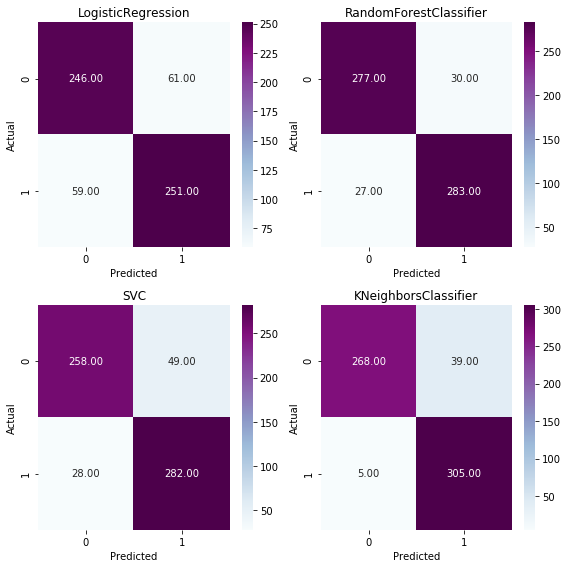

In [29]:
plt.figure(figsize=(8,8))
def plot_conf_matrix(i,j,k, model, title_name, y_test, y_pred):        
    ax = plt.subplot(i,j,k, title = title_name)
    sns.heatmap(confusion_matrix(y_test, y_pred),
                cmap = 'BuPu',
                annot=True,            
                fmt='0.2f') 
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()   
    #plt.subplots_adjust(hspace=0.5)

for i,elem in enumerate(clf_models,1):
    current_model = model_names[i-1]
    plot_conf_matrix(2,2,i, elem, current_model, y_test, dict_y_pred[current_model])

### Receiver Operating Characteristics (ROC) Curve

<Figure size 576x576 with 0 Axes>

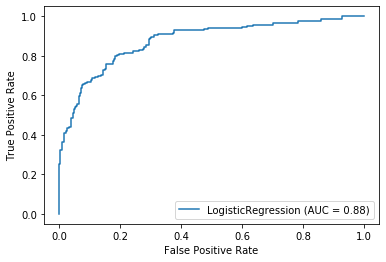

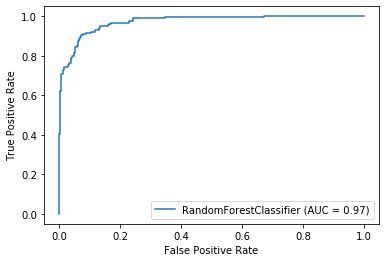

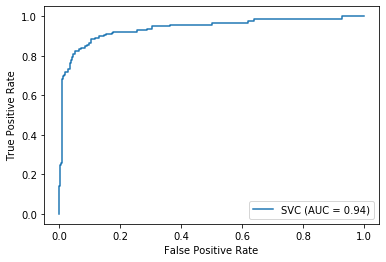

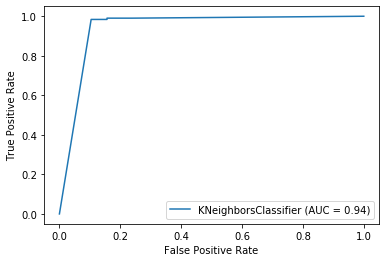

In [30]:
plt.figure(figsize=(8,8))
for i,elem in enumerate(clf_models,1):               
    plot_roc_curve(dict_m[model_names[i-1]], X_test, y_test)
    plt.show()

### Visualize metrics

     Classification Model  recall score
0      LogisticRegression      0.809677
1  RandomForestClassifier      0.896774
2                     SVC      0.909677
3    KNeighborsClassifier      0.983871

     Classification Model  precision score
0      LogisticRegression         0.804487
1  RandomForestClassifier         0.919614
2                     SVC         0.851964
3    KNeighborsClassifier         0.886628

     Classification Model  f1 score
0      LogisticRegression  0.807074
1  RandomForestClassifier  0.901639
2                     SVC  0.879875
3    KNeighborsClassifier  0.932722

     Classification Model  accuracy score
0      LogisticRegression        0.805511
1  RandomForestClassifier        0.894652
2                     SVC        0.875203
3    KNeighborsClassifier        0.928687

     Classification Model  roc_auc score
0      LogisticRegression       0.805490
1  RandomForestClassifier       0.912493
2                     SVC       0.875034
3    KNeighborsClassifier  

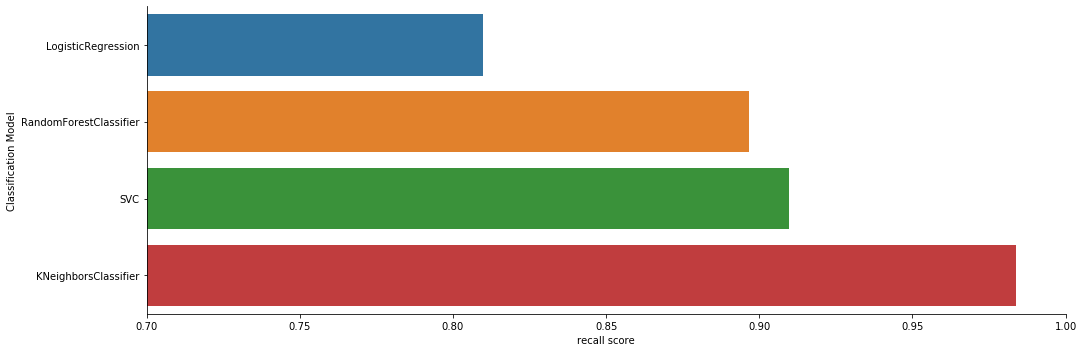

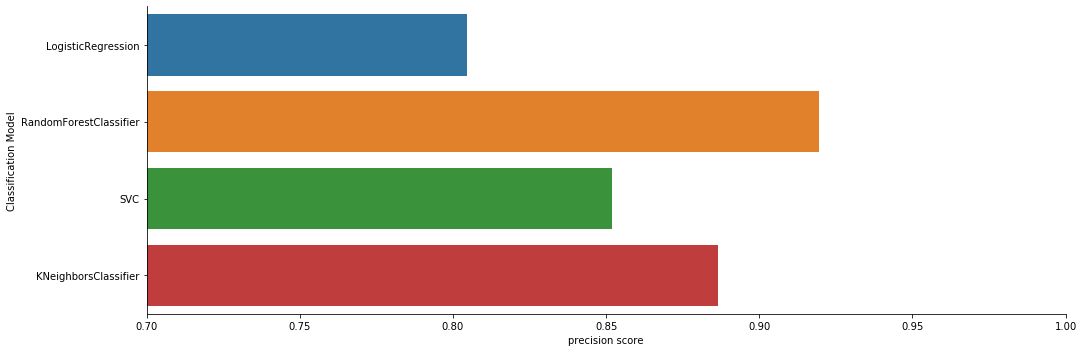

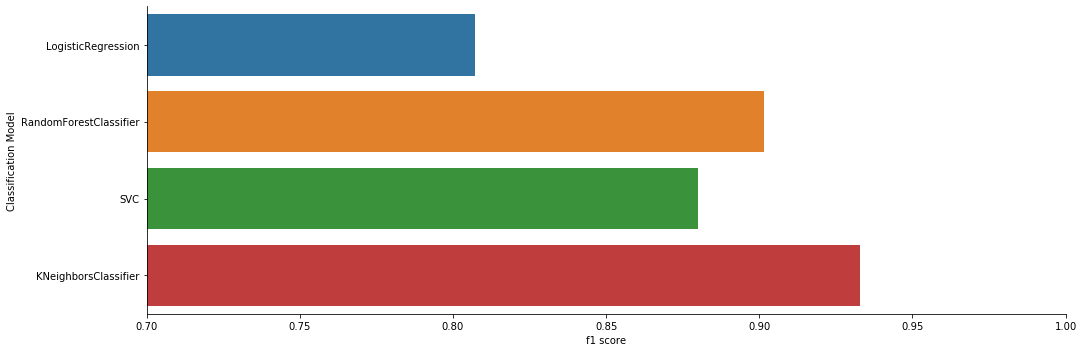

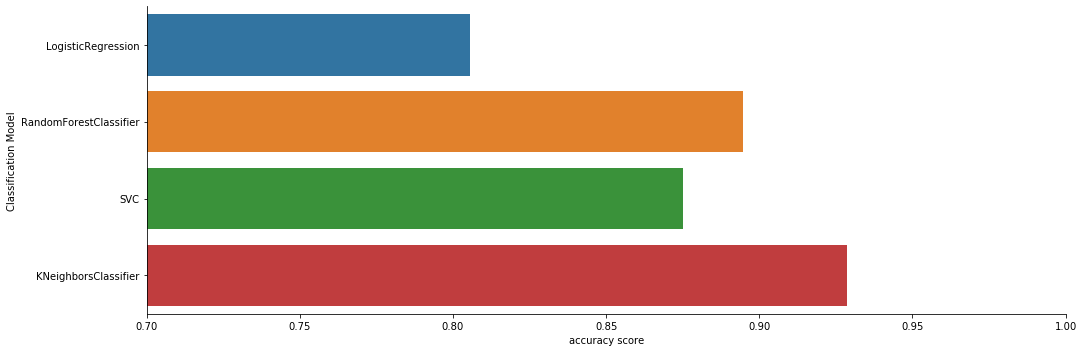

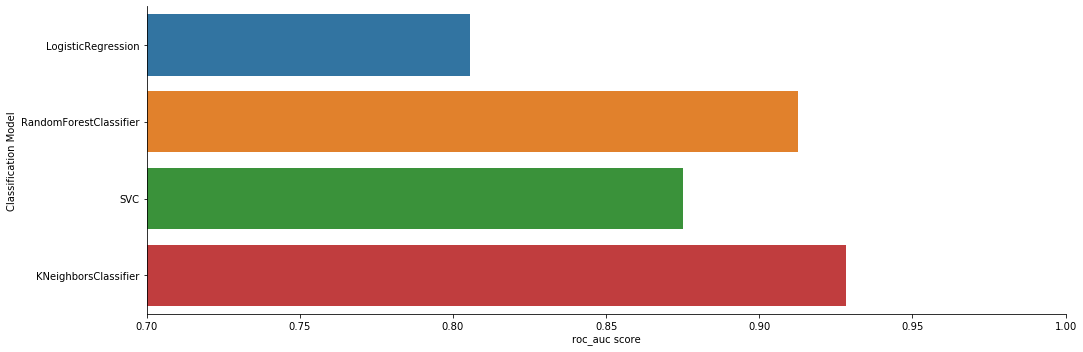

In [31]:
def metrics_calculation(metr):
    results=[]
    for reg in clf_models:    
        reg.fit(X_train,y_train)
        y_pred=reg.predict(X_test)
        if metr == 'recall':
            results.append(recall_score(y_test,y_pred))
        elif metr == 'precision':
            results.append(precision_score(y_test,y_pred))
        elif metr == 'f1':
            results.append(f1_score(y_test,y_pred))
        elif metr == 'accuracy':
            results.append(accuracy_score(y_test,y_pred))
        elif metr == 'roc_auc':
            results.append(roc_auc_score(y_test,y_pred))
    # print scores
    dict_score={'Classification Model':model_names, f'{metr} score':results}   
    df_score=pd.DataFrame(dict_score)
    print(str(df_score) + '\n')
    # plot scores
    fig = sns.catplot(y='Classification Model', x=f'{metr} score',
                data=df_score, kind='bar', height=5, aspect=3)
    fig.set(xlim=(0.7, 1.0))
    
metrics_list=['recall', 'precision', 'f1', 'accuracy', 'roc_auc']
for elem in metrics_list:
    metrics_calculation(elem)